# Necessary imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys

# Change this depending on where in the PSC folder you put the notebook

sys.path.append('../')


import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from scipy.linalg import qr
import scipy.stats as stats
import pandas as pd

from pymanopt.manifolds.stiefel import Stiefel


from PSC.utils import projection_cost, nuc_cost
from PSC.projections import manopt_alpha, PCA, pi_alpha_all, yhat_alpha_all

# Functions

In [2]:
def phi_on_line(a, b, point):
    if point <=a or point >=b:
        return 0.0
    else:
        return (np.cos(np.pi*(point-(a+b)/2)/(b-a)))**2
    

def phi_on_circle(a, b):
    def inner_function(point):
        point = point % 1
        if b < a:
            if 0 <= point < b:
                point = point + 1
                return phi_on_line(a, 1+b, point)
            else:
                return phi_on_line(a, 1+b, point)
        else:
            return phi_on_line(a, b, point)
    return inner_function


def mobius_transition_function(k,l, max):
    if k == 1 and l == max:
        return -1.0
    elif k == max and l == 1:
        return 1.0
    elif k == l-1:
        return 1.0
    elif k == l+1:
        return -1.0
    elif k == l:
        return 1.0
    else:
        return 0.0
    # if k <= l:
    #     return 1
    # else:
    #     return -1
    # if k == l - 1:
    #     return 1
    # elif k == l + 1:
    #     return -1
    # else:
    #     return 0.0
    

def normalized_phi_on_circle(a, b, list_of_unnormalized_phis):
    def inner_function(point):
        norm_factor = 0.0
        for phi_function in list_of_unnormalized_phis:
            value = phi_function(point)
            norm_factor = norm_factor + value
        return (phi_on_circle(a,b)(point))/norm_factor
    return inner_function


# Generate data

In [3]:
list_projection_costs_for_alpha_random = np.array([])
list_projection_costs_for_alpha_pca = np.array([])
list_projection_costs_for_alpha_gd_from_pca = np.array([])
list_projection_costs_for_alpha_gd_from_random = np.array([])





In [4]:
# SAMPLE POINTS ON S^1 = V_1(R^2)
# Define the range
a, b = 0.0, 0.999999

# Number of points
num_points = 1000

# Generate random points in the range (a, b)
sampled_circle_points = a + (b - a) * np.random.rand(num_points)


# SET HYPERPARAMETERS FOR RUN
N = 25
n = 2
k = 1

size_of_open_sets = 2/N

step_size = 1/N

# Define the start and end points
start = 0.0
end = 1 - step_size

# Create the list of intervals
list_of_open_sets = np.array([[i, (i + size_of_open_sets)%1] for i in np.arange(start, end + step_size, step_size)])
list_of_open_sets


list_of_phis_on_circle = []
for open_set in list_of_open_sets:
    phi = phi_on_circle(open_set[0], open_set[1])
    list_of_phis_on_circle.append(phi)
list_of_phis_on_circle = np.array(list_of_phis_on_circle)
list_of_phis_on_circle






# EMBED POINTS IN V_k(R^N)
points_in_V_k_R_N = np.zeros((N, num_points))

epsilon = 0.0

for (circle_index, point) in enumerate(sampled_circle_points):
    print(f'Working on index {circle_index} out of {sampled_circle_points.shape[0]}')
    # Find a U_l that contains the point
    index_of_containing_open_set = -1
    found_open_set = False
    while found_open_set == False:
        index_of_containing_open_set = index_of_containing_open_set + 1
        if list_of_open_sets[index_of_containing_open_set][0] < list_of_open_sets[index_of_containing_open_set][1] and list_of_open_sets[index_of_containing_open_set][0] < point < list_of_open_sets[index_of_containing_open_set][1]:
            found_open_set = True
            print(index_of_containing_open_set)
        if list_of_open_sets[index_of_containing_open_set][0] > list_of_open_sets[index_of_containing_open_set][1] and list_of_open_sets[index_of_containing_open_set][0] < point < 1 + list_of_open_sets[index_of_containing_open_set][1]:
            found_open_set = True
            print(index_of_containing_open_set)
        if list_of_open_sets[index_of_containing_open_set][0] > list_of_open_sets[index_of_containing_open_set][1] and point < list_of_open_sets[index_of_containing_open_set][1]:
            found_open_set = True
            print(index_of_containing_open_set)

    vector = np.zeros((N))

    for row_index in range(N):
        open_set_a = list_of_open_sets[row_index][0]
        open_set_b = list_of_open_sets[row_index][1]
        sign = mobius_transition_function(row_index, index_of_containing_open_set, N)
        phi_function = normalized_phi_on_circle(open_set_a, open_set_b, list_of_phis_on_circle)
        value = sign*np.sqrt(phi_function(point))
        vector[row_index] = value


    
    points_in_V_k_R_N[:,circle_index] = vector



# RESHAPE POINTS IN V_k(R^N)
ys = np.zeros((num_points, N, k))
for index in range(num_points):
    ys[index, :, 0] = points_in_V_k_R_N[:,index]






# DO DIMENSIONALITY REUDCTION WITH VARIOUS ALPHA'S
St_Nn = Stiefel(N, n)
alpha_random = St_Nn.random_point() # for comparison
alpha_PCA = PCA(ys, n)
alpha_GD_from_PCA = manopt_alpha(ys, alpha_PCA)
alpha_GD_from_random = manopt_alpha(ys, alpha_random)





# GET L2 PROJECTION COSTS FOR EACH ALPHA
# L2 projection costs for random
random_l2_projection_costs = []

yhats = yhat_alpha_all(alpha_random, ys)

for index in range(yhats.shape[0]):
    yhat = yhats[index, :, 0]
    alpha_random_yhat = alpha_random@yhat.T
    y = ys[index, :, 0]
    distance = np.linalg.norm(y - alpha_random_yhat)
    random_l2_projection_costs.append(distance)


# L2 projection costs for PCA
pca_l2_projection_costs = []

yhats = yhat_alpha_all(alpha_PCA, ys)

for index in range(yhats.shape[0]):
    yhat = yhats[index, :, 0]
    alpha_PCA_yhat = alpha_PCA@yhat.T
    y = ys[index, :, 0]
    distance = np.linalg.norm(y - alpha_PCA_yhat)
    pca_l2_projection_costs.append(distance)


# L2 projection costs for gradient descent from pca
gd_from_pca_l2_projection_costs = []

yhats = yhat_alpha_all(alpha_GD_from_PCA, ys)

for index in range(yhats.shape[0]):
    yhat = yhats[index, :, 0]
    alpha_GD_yhat = alpha_GD_from_PCA@yhat.T
    y = ys[index, :, 0]
    distance = np.linalg.norm(y - alpha_GD_yhat)
    gd_from_pca_l2_projection_costs.append(distance)


# L2 projection costs for gradient descent from random
gd_from_random_l2_projection_costs = []

yhats = yhat_alpha_all(alpha_GD_from_random, ys)

for index in range(yhats.shape[0]):
    yhat = yhats[index, :, 0]
    alpha_GD_yhat = alpha_GD_from_random@yhat.T
    y = ys[index, :, 0]
    distance = np.linalg.norm(y - alpha_GD_yhat)
    gd_from_random_l2_projection_costs.append(distance)



# FINAL COST CALCULATIONS
cost_for_random = 0.0
for distance in random_l2_projection_costs:
    cost_for_random = cost_for_random + (distance)**2
cost_for_random = np.sqrt(cost_for_random)

cost_for_pca = 0.0
for distance in pca_l2_projection_costs:
    cost_for_pca = cost_for_pca + (distance)**2
cost_for_pca = np.sqrt(cost_for_pca)

cost_for_gd_from_pca = 0.0
for distance in gd_from_pca_l2_projection_costs:
    cost_for_gd_from_pca = cost_for_gd_from_pca + (distance)**2
cost_for_gd_from_pca = np.sqrt(cost_for_gd_from_pca)

cost_for_gd_from_random = 0.0
for distance in gd_from_random_l2_projection_costs:
    cost_for_gd_from_random = cost_for_gd_from_random + (distance)**2
cost_for_gd_from_random = np.sqrt(cost_for_gd_from_random)


list_projection_costs_for_alpha_random = np.append(list_projection_costs_for_alpha_random, cost_for_random)
list_projection_costs_for_alpha_pca = np.append(list_projection_costs_for_alpha_pca, cost_for_pca)
list_projection_costs_for_alpha_gd_from_pca = np.append(list_projection_costs_for_alpha_gd_from_pca, cost_for_gd_from_pca)
list_projection_costs_for_alpha_gd_from_random = np.append(list_projection_costs_for_alpha_gd_from_random, cost_for_gd_from_random)



Working on index 0 out of 1000
13
Working on index 1 out of 1000
4
Working on index 2 out of 1000
11
Working on index 3 out of 1000
7
Working on index 4 out of 1000
22
Working on index 5 out of 1000
14
Working on index 6 out of 1000
8
Working on index 7 out of 1000
13
Working on index 8 out of 1000
7
Working on index 9 out of 1000
13
Working on index 10 out of 1000
20
Working on index 11 out of 1000
15
Working on index 12 out of 1000
20
Working on index 13 out of 1000
0
Working on index 14 out of 1000
11
Working on index 15 out of 1000
21
Working on index 16 out of 1000
21
Working on index 17 out of 1000
23
Working on index 18 out of 1000
10
Working on index 19 out of 1000
10
Working on index 20 out of 1000
19
Working on index 21 out of 1000
12
Working on index 22 out of 1000
13
Working on index 23 out of 1000
10
Working on index 24 out of 1000
5
Working on index 25 out of 1000
16
Working on index 26 out of 1000
19
Working on index 27 out of 1000
16
Working on index 28 out of 1000
0
Wo

# Analyze results

In [5]:
yhats_random = yhat_alpha_all(alpha_random, ys)[:,:,0]
yhats_PCA = yhat_alpha_all(alpha_PCA, ys)[:,:,0]
yhats_GD_from_PCA = yhat_alpha_all(alpha_GD_from_PCA, ys)[:,:,0]
yhats_GD_from_random = yhat_alpha_all(alpha_GD_from_random, ys)[:,:,0]

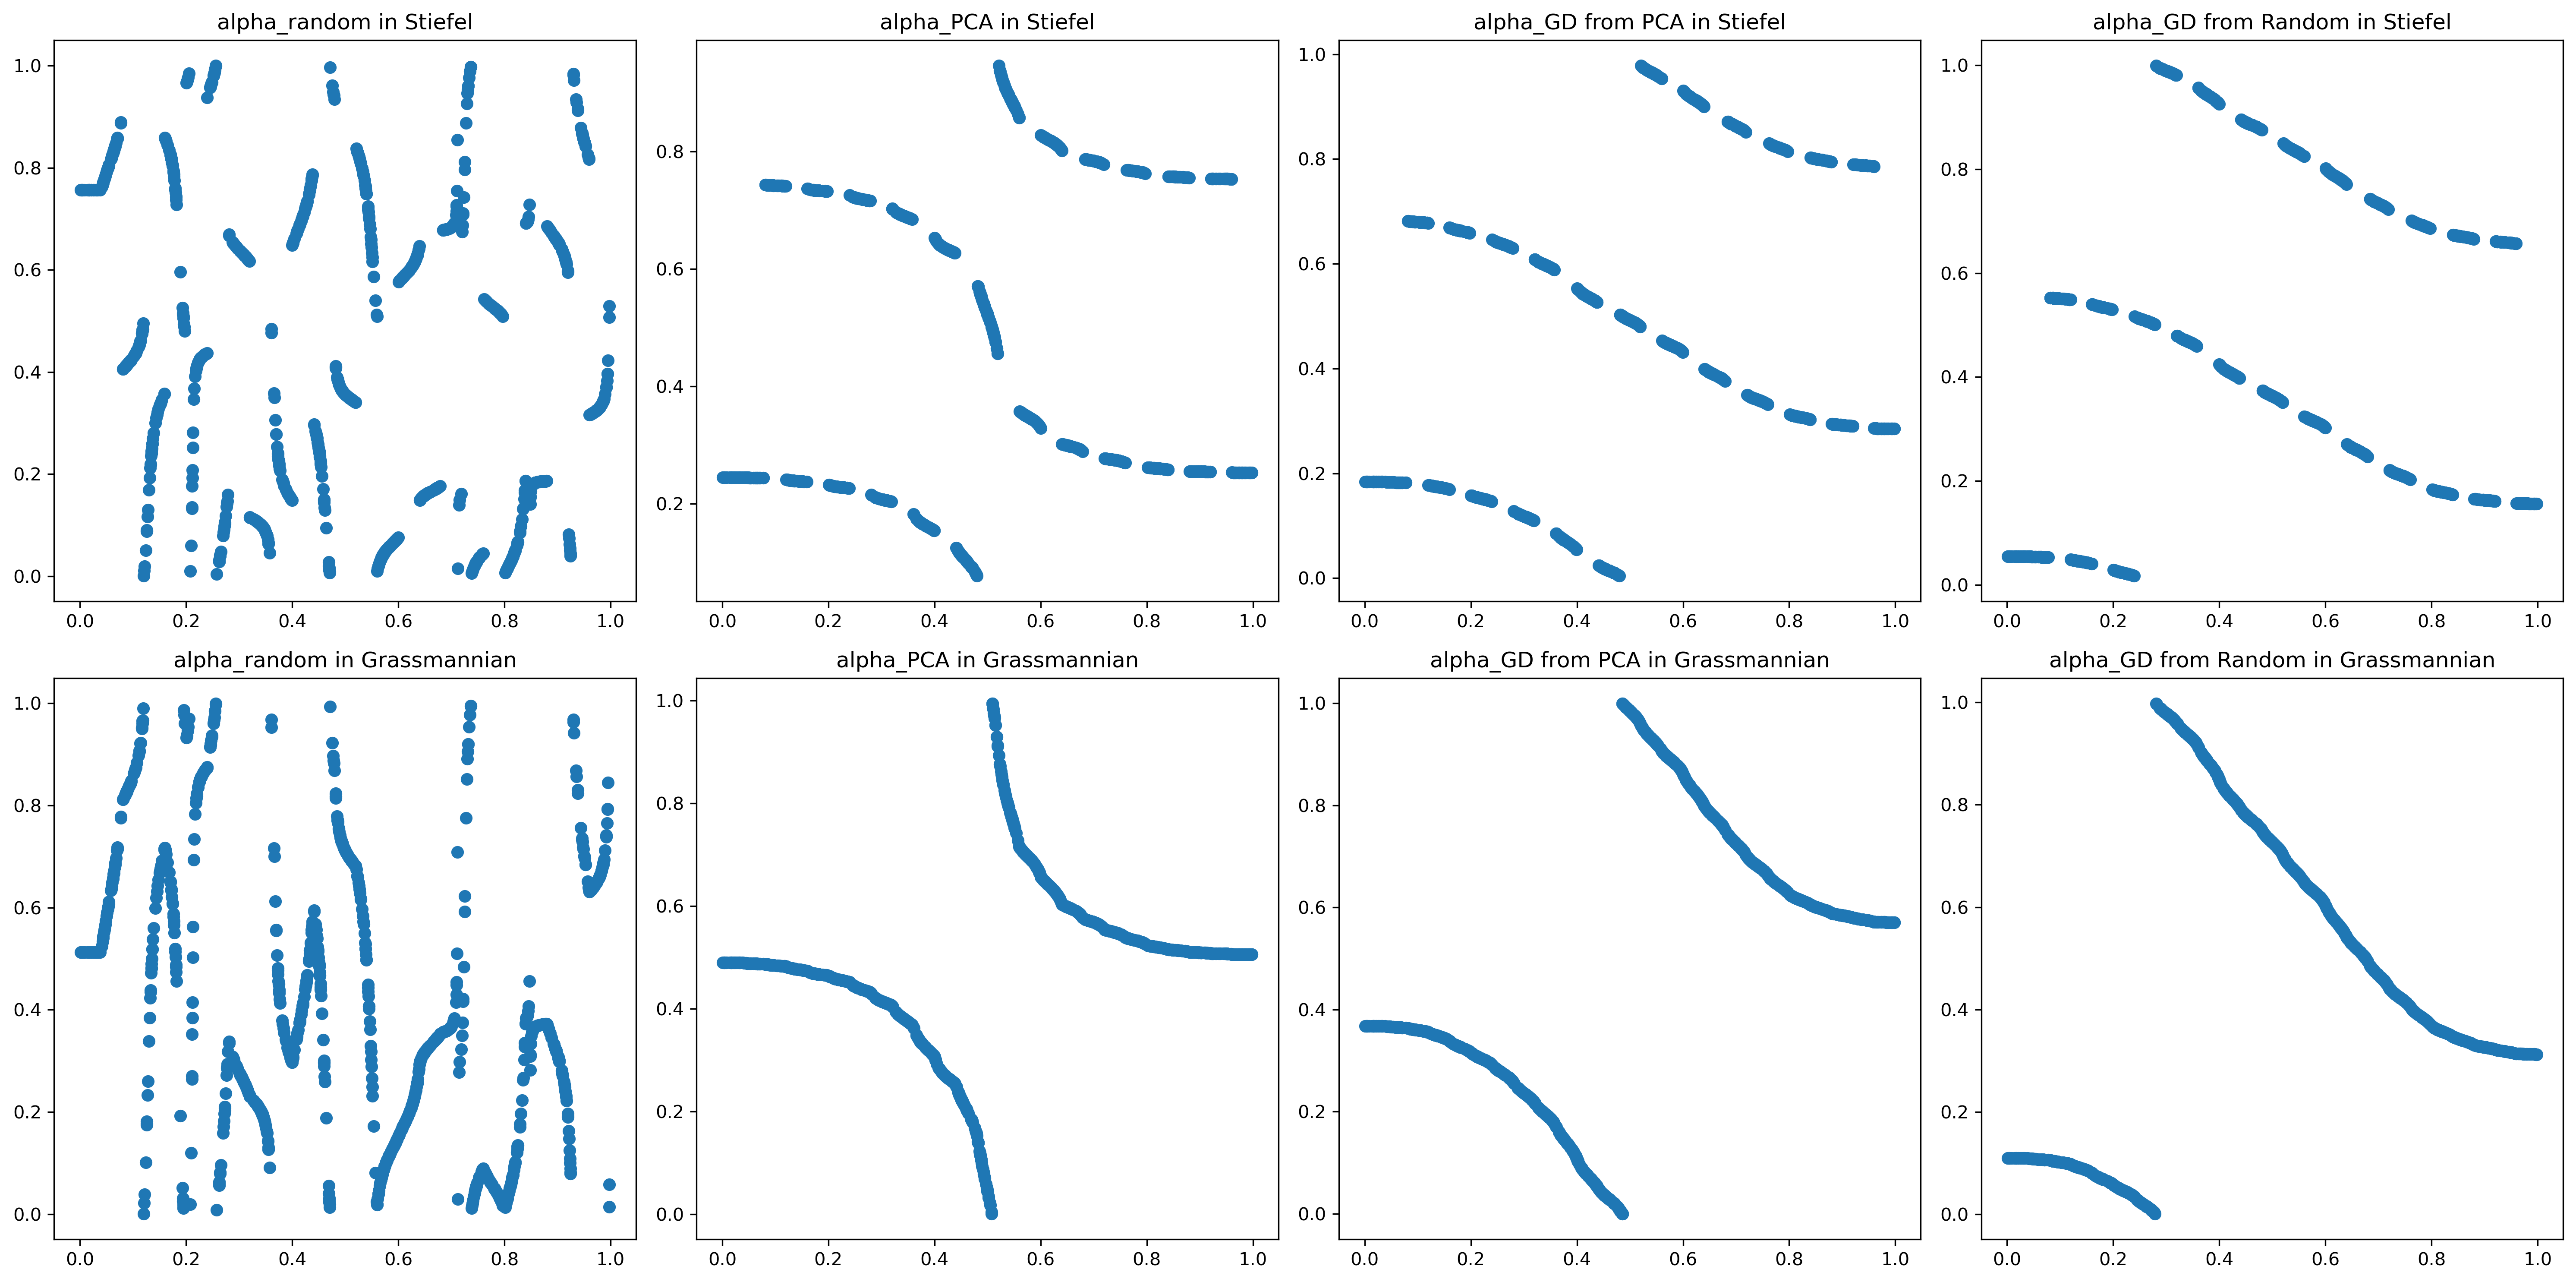

In [6]:
# Assuming sampled_circle_points, yhats_random, yhats_PCA, yhats_GD_from_PCA, and yhats_GD_from_random are already defined
yhats_arrays = [yhats_random, yhats_PCA, yhats_GD_from_PCA, yhats_GD_from_random]
titles = ['alpha_random in Stiefel', 'alpha_PCA in Stiefel', 'alpha_GD from PCA in Stiefel', 'alpha_GD from Random in Stiefel',
          'alpha_random in Grassmannian', 'alpha_PCA in Grassmannian', 'alpha_GD from PCA in Grassmannian', 'alpha_GD from Random in Grassmannian']

fig, axs = plt.subplots(2, 4, figsize=(20, 10), dpi = 300)

for i, base_array in enumerate(yhats_arrays):
    angles_in_stiefel = []
    for index in range(base_array.shape[0]):
        angle = np.arctan2(base_array[index, 1], base_array[index, 0])
        angle = angle + np.pi
        angle = angle / (2 * np.pi)
        angles_in_stiefel.append(angle)
    angles_in_stiefel = np.array(angles_in_stiefel)

    angles_in_grassmannian = []
    for angle in angles_in_stiefel:
        angle = angle % 0.5
        angle = 2 * angle
        angles_in_grassmannian.append(angle)
    angles_in_grassmannian = np.array(angles_in_grassmannian)

    # Plotting in Stiefel
    ax = axs[i // 4, i % 4]
    ax.scatter(sampled_circle_points, angles_in_stiefel)
    ax.set_title(titles[i])

    # Plotting in Grassmannian
    ax = axs[(i // 4) + 1, i % 4]
    ax.scatter(sampled_circle_points, angles_in_grassmannian)
    ax.set_title(titles[i + 4])

plt.tight_layout()
plt.show()


In [7]:
norms = []
for index in range(len(ys)):
    value = np.linalg.norm(ys[index])
    norms.append(value)

In [8]:
list_projection_costs_for_alpha_gd_from_pca

array([35.56036061])

In [9]:
list_of_open_sets

array([[0.  , 0.08],
       [0.04, 0.12],
       [0.08, 0.16],
       [0.12, 0.2 ],
       [0.16, 0.24],
       [0.2 , 0.28],
       [0.24, 0.32],
       [0.28, 0.36],
       [0.32, 0.4 ],
       [0.36, 0.44],
       [0.4 , 0.48],
       [0.44, 0.52],
       [0.48, 0.56],
       [0.52, 0.6 ],
       [0.56, 0.64],
       [0.6 , 0.68],
       [0.64, 0.72],
       [0.68, 0.76],
       [0.72, 0.8 ],
       [0.76, 0.84],
       [0.8 , 0.88],
       [0.84, 0.92],
       [0.88, 0.96],
       [0.92, 0.  ],
       [0.96, 0.04]])

In [10]:
list_projection_costs_for_alpha_pca

array([38.7700038])